In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
from gloomhaven.render import render_table
from gloomhaven import GloomhavenDeck, read_deck

import time

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:58037 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GiB


In [3]:
deck = read_deck("decks/Soothsinger.yaml")

In [4]:
deck

Soothsinger
Cards: Miss, 1, 2, 2x, 4, 4, 1, 1, 2, 2, 2, 3, 0, c1, c1, c1
Current Deck: 

In [5]:
@dask.delayed
def simulate(deck, n, base_attack):
    attacks = []
    deck.shuffle_deck()
    for _ in range(n):
        attacks.append(deck.get_attack(base_attack))
    return attacks

In [6]:
attack_data = {}
summary_attack_data = {}
base_attacks = [1, 2, 3, 4, 5]
samp_size = 10_000

attack_data = {}
for val in base_attacks:
    attack_data[f"base_attack_{val}"] = simulate(deck.copy(), samp_size, val)

In [7]:
attack_data = dask.compute(attack_data)
attack_data = pd.DataFrame(attack_data[0])

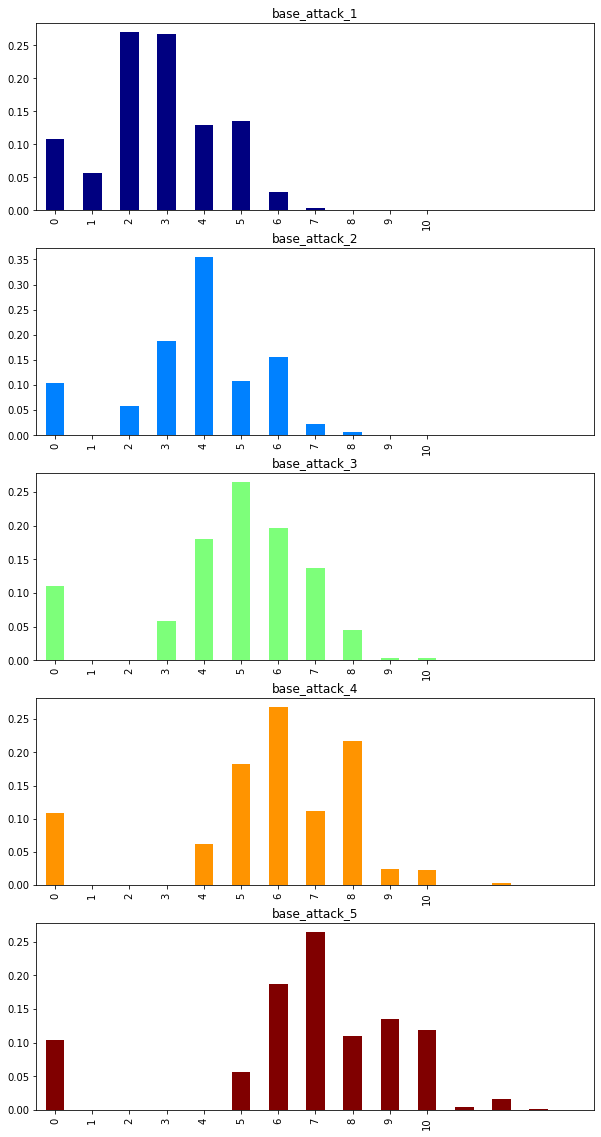

In [8]:
_ = attack_data.apply(lambda x: x.value_counts() / samp_size, axis=0) \
    .plot(
        kind="bar",
        subplots=True, 
        figsize=(10,20),
        legend=False,
        colormap="jet",
        sharex=False,
        xticks=[i for i in range(max(base_attacks)*2+1)],
    )
plt.savefig("./assets/pdfs.jpg")

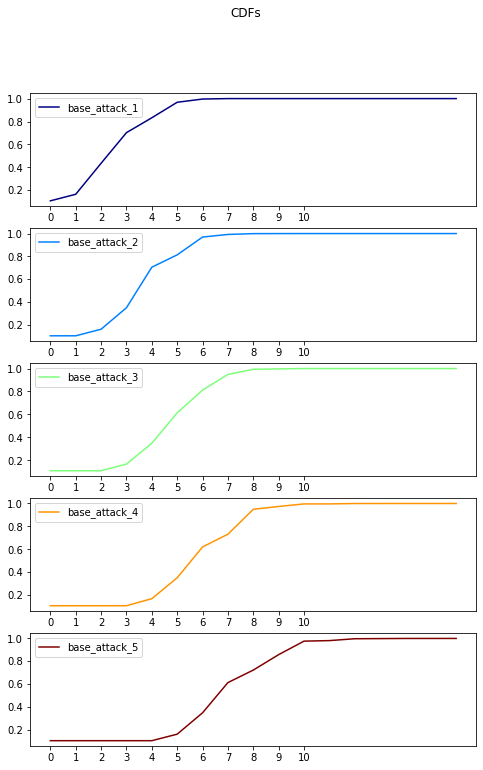

In [9]:
_ = attack_data.apply(lambda x: x.value_counts() / samp_size, axis=0) \
    .fillna(0) \
    .cumsum() \
    .plot(
        kind="line",
        subplots=True, 
        figsize=(8, 12),
        colormap="jet",
        sharex=False,
        xticks=[i for i in range(max(base_attacks)*2+1)],
        title="CDFs"
    )

tmp = attack_data.apply(lambda x: x.value_counts(normalize=True), axis=0)
missing = [i for i in range(max(tmp.index)) if i not in tmp.index]
for i in missing:
    tmp.loc[i, :] = None
tmp = tmp.fillna(0)
tmp.sort_index(axis=0, inplace=True)
tmp = tmp.cumsum()
tmp_table = tmp.to_html(classes="table", border=0)

with open("./assets/cdfs.html", "w") as f:
    f.write(render_table(tmp_table))

In [10]:
def mode(x):
    return x.value_counts().index[0]

tmp = attack_data.agg(["min", "median", "max", "mean", "std", mode])
tmp_table = tmp.to_html(classes="table", border=0)

with open("./assets/summary_stats.html", "w") as f:
    f.write(render_table(tmp_table))

tmp

,base_attack_1,base_attack_2,base_attack_3,base_attack_4,base_attack_5
min,0.000000,0.000000,0.000000,0.000000,0.000000
median,3.000000,4.000000,5.000000,6.000000,7.000000
max,7.000000,10.000000,12.000000,14.000000,16.000000
mean,2.789300,3.798800,4.787600,5.770100,6.824100
std,1.555554,1.767493,2.100745,2.453008,2.796237
mode,2.000000,4.000000,5.000000,6.000000,7.000000
